In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import NumericalExample1Funcs as ne

## Load and explore the dataset

In [3]:
# Load data
data = ne.GetDataset('TrainingData/NLheatDataset.json')

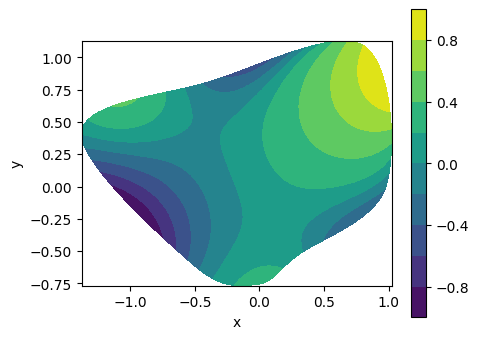

In [4]:
# Plot an example
idx_data = 11 #pick a idx in the dataset
nodes = data[idx_data]['nodes']
elements = data[idx_data]['elements']
vals = data[idx_data]['l']

ne.PlotFEMsolution(nodes, elements, vals)

## Load a trained model

In [5]:
# Load the model
encoder,encoderB,decoder,P,history,hyperParams = ne.LoadModels('Models/LaplaceNL_FEM/model_1_12')
r = hyperParams['n_latent']
inputMaskB = np.array(hyperParams['s_alphaBE'])
nodesIE = np.array(hyperParams['nodesIE'])
nodesD = np.array(hyperParams['nodesD'])

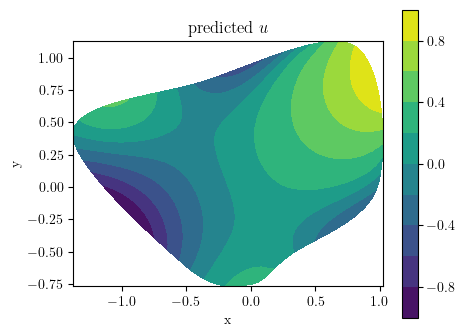

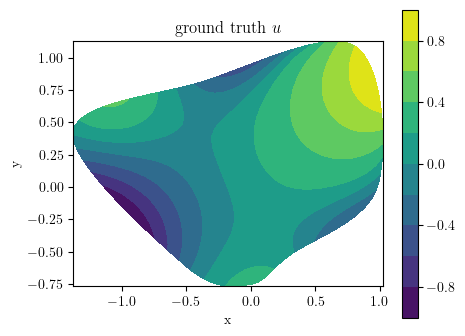

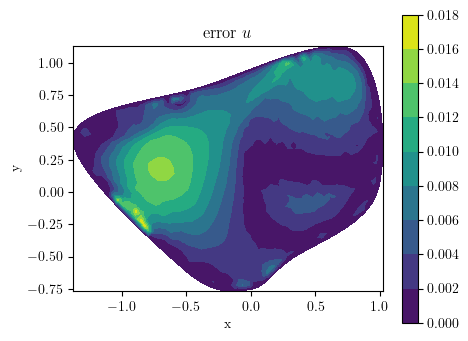

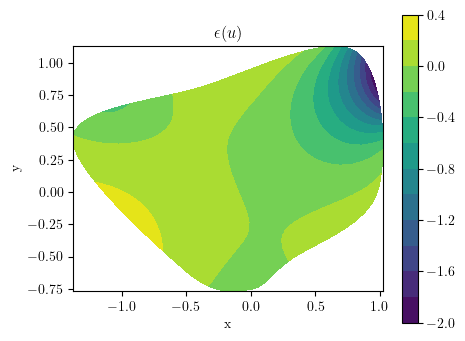

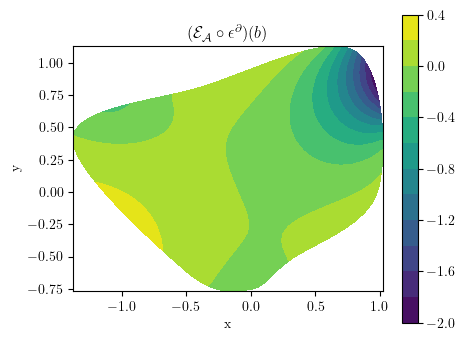

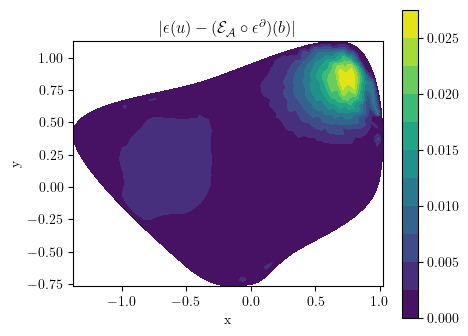

In [34]:
idx_data = 11 #pick a idx in the dataset

u_model,l_model = ne.SINNsPredict(data[idx_data],encoderB,decoder,P,r,inputMaskB)
l_enc = ne.EncodeData(data[idx_data],encoder,encoderB, nodesIE, inputMaskB)
u = data[idx_data]['l']
nodes = data[idx_data]['nodes']
elements = data[idx_data]['elements']

ne.PlotFEMsolution(nodes, elements,u_model,title='predicted $u$')
ne.PlotFEMsolution(nodes, elements,u,title='ground truth $u$')
ne.PlotFEMsolution(nodes, elements,np.abs(u_model-u),title='error $u$')

ne.PlotFEMsolution(nodes, elements,l_model,title = '$\epsilon(u)$')
ne.PlotFEMsolution(nodes, elements,l_enc, title = '$(\mathcal{E}_{\mathcal{A}} \circ \epsilon^{\partial})(b)$')
ne.PlotFEMsolution(nodes, elements,np.abs(l_model-l_enc), title = '$|\epsilon(u) - (\mathcal{E}_{\mathcal{A}} \circ \epsilon^{\partial})(b)|$')

## Train a model

In [ ]:
@tf.function
def TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, r, fd_l_weight, elliptc_weight):

    with tf.GradientTape() as enc_tape, tf.GradientTape() as encB_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as b_tape:
        A = ne.GetA(B)
        lossI, loglossI = ne.InteriorForwardPass(encoder, decoder, A, r, *batchI, fd_l_weight, elliptc_weight)
        lossB, loglossB = ne.BoundaryForwardPass(encoder, encoderB, decoder, A, r, *batchB, fd_l_weight, elliptc_weight)
        loss = tf.concat([lossI,lossB],0)

    grads_enc = enc_tape.gradient(loss,encoder.trainable_variables)
    grads_encB = encB_tape.gradient(loss,encoderB.trainable_variables)
    grads_dec = dec_tape.gradient(loss,decoder.trainable_variables)
    grads_b = b_tape.gradient(loss,B)
    optimizer.apply_gradients(zip(grads_enc,encoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_dec,decoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_encB,encoderB.trainable_variables))
    optimizer.apply_gradients(zip([grads_b],[B]))

    return loglossI+loglossB

def TrainModel(encoder, encoderB, decoder, B, optimizer, dataset, dataset_b, r, epochs, n_batches, fd_l_weight, elliptc_weight, history=None, data_test=None, data_train=None):
    if history is None:
        history = {'loss':[], 'loss_i':[], 'loss_b':[], 'loss_c': [],'r_loss_i':[],'r_loss_b':[],'r_loss_c':[],'fd_l_loss_i':[],'fd_l_loss_b':[],'fd_l_loss_c':[],'elliptic_loss':[],'err_train':[],'err_test':[],'err_epoch':[]}
    history_epoch = np.zeros((n_batches,8))
    for epoch in range(epochs):
        for i, (batchI, batchB) in enumerate(zip(dataset,dataset_b)):
            logloss = TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, r, fd_l_weight, elliptc_weight)
            history_epoch[i,:] = logloss
            print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='\r')
        
        logloss = history_epoch.mean(0)
        history['loss'].append((logloss[0]+logloss[4])/2)
        history['loss_i'].append(logloss[0])
        history['loss_b'].append(logloss[4])
        history['r_loss_i'].append(logloss[1])
        history['r_loss_b'].append(logloss[5])
        history['fd_l_loss_i'].append(logloss[2])
        history['fd_l_loss_b'].append(logloss[6])
        history['elliptic_loss'].append(logloss[3])
        print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='')

        if (data_test is not None) and ((epoch+1)%5 == 0):
            err_arr = np.zeros((len(data_test)))
            for i in range(len(data_test)):
                err_arr[i] = ne.SINNsEvalErr(data_test[i],encoderB,decoder,B,r,inputMaskB)
            history['err_test'].append(err_arr.mean())
            history['err_epoch'].append(len(history['loss'])-1)
            print(f'; err_test: {err_arr.mean():.4g}', end='')
            if (data_train is not None):
                err_arr_train = np.zeros((len(data_train)))
                for i in range(len(data_train)):
                    err_arr_train[i] = ne.SINNsEvalErr(data_train[i],encoderB,decoder,B,r,inputMaskB)
                history['err_train'].append(err_arr_train.mean())
                print(f'; err_train: {err_arr_train.mean():.4g}', end='')
            print()
        else:
            print()

    return history

batch_size = [64,64]
n_batches = 1_000
n_epochs = 30
layers = [32,32,32]
hyperParams = {'N_interiorEncoder': None, 'd_interiorEncoder': 1, 'layers_interiorEncoder': layers,
               'N_boundarEncoder': None, 'd_boundarEncoder': 1, 'layers_boundarEncoder': layers,
               'N_decoderOut': None, 'd_decoderOut': 1, 'layers_decoder': layers,
               'n_latent': 1, 'activation': 'relu', 'elSizeMax': 0.10, 'elSizeMin': 0.0999,
               'nIE1': 0, 'nIE2': 8, 'kIE': 0.5, 'sizeIE': 0.1, 'typeIE': 'radial',
               'nBE': 1, 'kBE': 0.5, 'sizeBE': 0.0,
               'nD1': 0, 'nD2': 0, 'kD': 0.5, 'sizeD': 0.1,
               'fd_l_weight': 0.03, 'elliptc_weight': 0}

if hyperParams['typeIE'] == 'radial':
    nodesIE = ne.GetRadialEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
elif hyperParams['typeIE'] == 'squeare':
    nodesIE = ne.GetSquareEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
else:
    raise ValueError('typeIE must be either "radial" or "squeare"')

inputMaskB = ne.GetBoundaryEncoderInputMask(hyperParams['nBE'],k=hyperParams['kBE'],Esize=hyperParams['sizeBE'])
nodesD = ne.GetRadialEncoderInputMask(hyperParams['nD1'],hyperParams['nD2'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
hyperParams['N_interiorEncoder'] = nodesIE.shape[0]
hyperParams['N_boundarEncoder'] = inputMaskB.shape[0]
hyperParams['N_decoderOut'] = nodesD.shape[0]
hyperParams['nodesIE'] = nodesIE.tolist()
hyperParams['inputMaskB'] = inputMaskB.tolist()
hyperParams['nodesD'] = nodesD.tolist()

data_train = data[-20:]
data_test = data[:20]

dataset = ne.GetInteriorDatasetFixed(data_train, nodesIE, nodesD, batch_size=batch_size[0], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])
dataset_b = ne.GetBoundaryDatasetFixed(data_train, nodesIE, inputMaskB, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])

encoder,encoderB,decoder = ne.GetModels(hyperParams)
# P = tf.Variable(tf.constant(tf.eye(hyperParams['n_latent']*2),dtype=tf.float32))
P = tf.Variable(tf.constant(np.random.randn(hyperParams['n_latent']*2,hyperParams['n_latent']*2),dtype=tf.float32))
r = hyperParams['n_latent']

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, r, n_epochs, n_batches, fd_l_weight=hyperParams['fd_l_weight'], elliptc_weight=hyperParams['elliptc_weight'],data_test=data_test, data_train=data_train[:10])

### Plot the metrics during training
- loss - total loss
- r_loss - physical variable reconstruction loss
- l_loss - latent variable reconstruction loss
- err_test - MSE on the test dataset
- err_train - MSE on the test dataset

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(history['loss_i'],label='loss interior')
plt.plot(history['loss_b'],label='loss boundary')
plt.plot(history['loss'],label='loss total')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,2)
plt.plot(history['r_loss_i'],label='r_loss interior')
plt.plot(np.array(history['fd_l_loss_i'])*hyperParams['fd_l_weight'],'--',label='fd_loss interior')
plt.plot(history['r_loss_b'],label='r_loss boundary')
plt.plot(np.array(history['fd_l_loss_b'])*hyperParams['fd_l_weight'],'--',label='fd_loss boundary')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,3)
plt.plot(history['err_epoch'],history['err_test'],label='err_test')
plt.plot(history['err_epoch'],history['err_train'],label='err_train')
plt.legend()
plt.gca().set_yscale('log')

## Plot the learned and analytic encoding and decoding functions

1/1 [==============================] - 0s 9ms/step


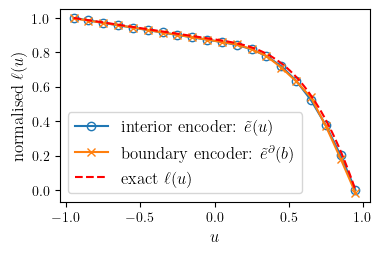

4/4 [==============================] - 0s 1ms/step


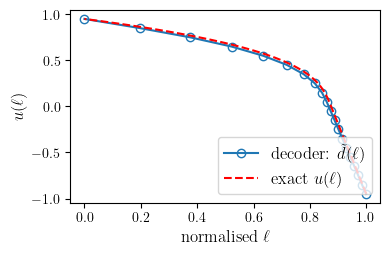

In [48]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

dpi=100
n_l = 20
u = np.linspace(-0.95,0.95,n_l)
# u = np.linspace(-1,1,100)
l_enc = encoder.predict([u.reshape(-1,1,1),np.zeros((n_l,1,1))])
# print(l_enc)
normals = np.zeros((n_l,1,2))
normals[:,0,0] = 1
l_encB = encoderB.predict([u.reshape(-1,1),normals])
l_encB = (l_encB-l_enc.min())/(l_enc.max()-l_enc.min())
l_max, l_min = l_enc.max(),l_enc.min()
l_enc = (l_enc-l_enc.min())/(l_enc.max()-l_enc.min())
u_exact = np.linspace(-0.95,0.95,100)
l_exact = np.zeros(100)
l_exact[:50] = u_exact[u_exact<=0]/2
l_exact[50:] = u_exact[u_exact>0]**3*10/3+u_exact[u_exact>0]/2
if l_exact[0] < l_exact[-1]:
    l_exact = -l_exact
    flip=True
else:
    flip=False
l_exact = (l_exact-l_exact.min())/(l_exact.max()-l_exact.min())
fig, ax = plt.subplots(figsize=(4,2.5), dpi=dpi)
plt.plot(u,l_enc,'-o',markerfacecolor='none')
plt.plot(u,l_encB,'-x')
plt.plot(u_exact,l_exact,'--r')
plt.legend(['interior encoder: $\\tilde{e}(u)$','boundary encoder: $\\tilde{e}^{\partial}(b)$','exact $\ell(u)$'],fontsize=12)
plt.ylabel('normalised $\ell(u)$',fontsize=12)
plt.xlabel('$u$',fontsize=12)
plt.show()

l = np.linspace(l_min,l_max,100)
if flip:
    l = l[::-1]
u_decoder = decoder.predict(l.reshape(-1,1))
l_dec = np.interp(u,u_decoder.flatten()[::],l[::])
# l_dec = np.interp(u,u_decoder.flatten()[::],l[::])
l_dec = (l_dec-l_dec.min())/(l_dec.max()-l_dec.min())
fig, ax = plt.subplots(figsize=(4,2.5), dpi=dpi)
plt.plot(l_dec,u,'-o',markerfacecolor='none')
# plt.gca().twiny()
plt.plot(l_exact,u_exact,'--r')
plt.legend(['decoder: $\\tilde{d}(\ell)$','exact $u(\ell)$'],loc='lower right',fontsize=12)
plt.xlabel('normalised $\ell$',fontsize=12)
plt.ylabel('$u(\ell)$',fontsize=12)
plt.show()